In [2]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

from multiple_shooting import setup_multiple_shooting
from cnlls_solver import solve_cnlls_ipopt, solve_cnlls_gauss_newton_logparam
from pyridine import make_pyridine_integrator, get_initial_state, get_true_parameters, simulate_pyridine_data
from notorious import make_notorious_integrator, get_initial_state as not_x0, get_true_parameters as not_p_true, simulate_notorious_measurements
from utils import add_noise, evaluate_fit


CasADi - 2025-05-22 18:03:13 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:698]



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2413
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2166

Total number of variables............................:      151
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      133
Total number of inequality c

CasADi - 2025-05-22 18:03:21 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:21 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:21 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:21 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:21 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:21 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:21 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.c

  14  2.8525380e-03 2.71e-03 5.89e-03  -3.8 2.71e+01    -  1.00e+00 1.25e-01h  4
  15  6.9776435e-04 7.53e-03 7.53e-03  -3.8 5.89e+00    -  1.00e+00 1.00e+00h  1
  16  3.6370312e-04 9.71e-04 1.32e-03  -3.8 2.31e+00  -4.4 1.00e+00 1.00e+00h  1
  17  6.0130224e-05 1.14e-03 1.29e-03  -5.7 4.36e+00    -  1.00e+00 1.00e+00h  1
  18  1.1520871e-05 1.95e-04 3.55e-04  -5.7 2.47e+00    -  1.00e+00 1.00e+00h  1
  19  2.2489286e-06 1.98e-04 4.35e-04  -5.7 4.66e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.5288468e-07 7.26e-05 1.16e-04  -5.7 4.41e+00    -  1.00e+00 1.00e+00h  1
  21  2.6980023e-08 2.81e-05 4.38e-05  -5.7 3.40e+00    -  1.00e+00 1.00e+00h  1
  22  3.9406461e-10 5.87e-06 7.19e-06  -5.7 1.33e+00    -  1.00e+00 1.00e+00h  1
  23  2.3638516e-13 2.04e-07 2.63e-07  -8.6 1.69e-01    -  1.00e+00 1.00e+00h  1
  24  1.2792542e-19 1.45e-10 1.89e-10  -8.6 3.35e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 2

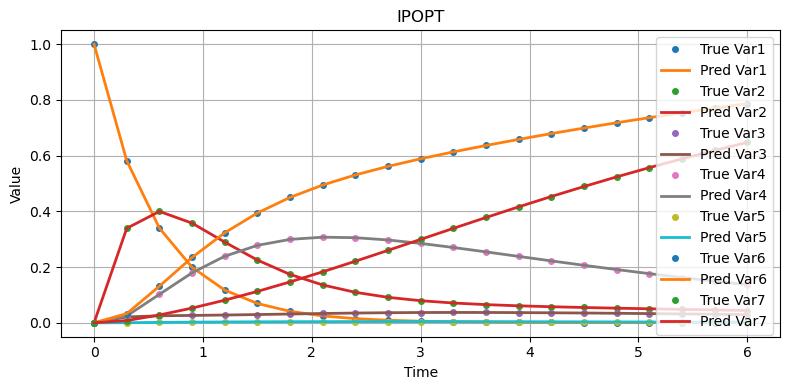


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



####################   qpOASES  --  QP

CasADi - 2025-05-22 18:03:27 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:27 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:27 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:27 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:27 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:27 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-05-22 18:03:27 WARNING("F:step failed: NaN detected for output xf, at (row 0, col 0).") [.../casadi/core/oracle_function.c


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



####################   qpOASES  --  QP

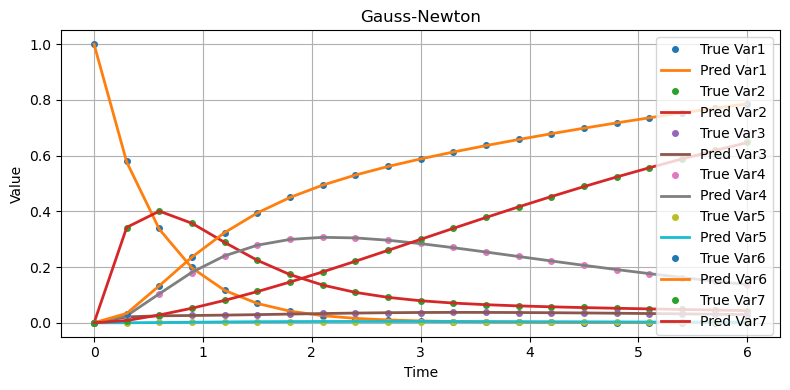

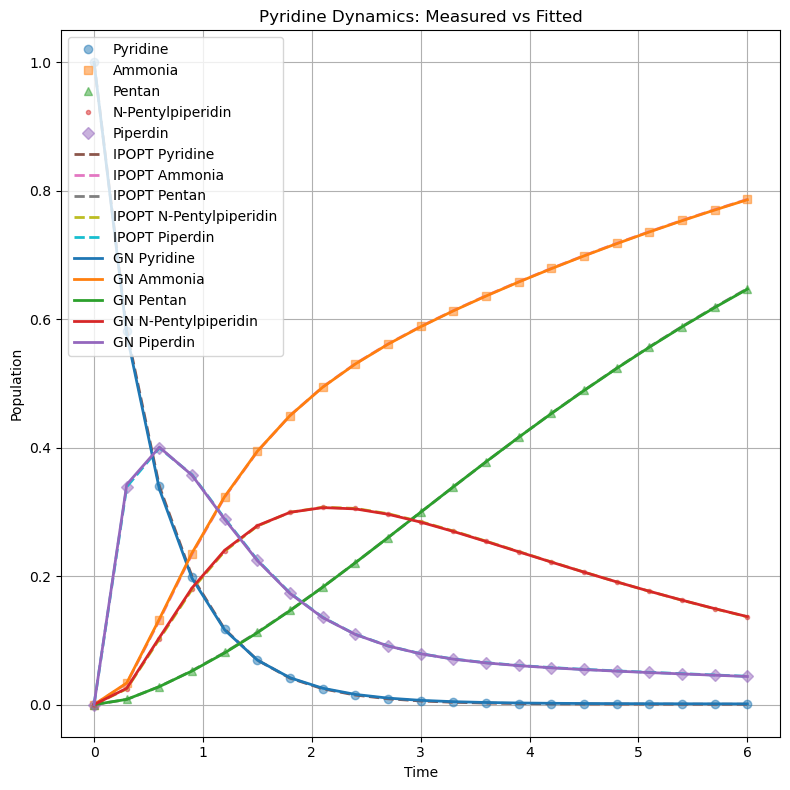

In [4]:
if __name__ == '__main__':
    N = 20
    nx = 7
    np_p = 11
    T = 6.0
    t_grid = np.linspace(0, T, N + 1)
    dt = t_grid[1] - t_grid[0]

    p_true = get_true_parameters()
    x0_true = get_initial_state()
    y_meas = simulate_pyridine_data(x0_true, p_true, t_grid)
    y_meas_noised = add_noise(y_meas, noise_level=0.0)
    y_meas_noised[0, :] = y_meas[0, :]

    F = make_pyridine_integrator(dt)
    w, X_end, g, S_vars, P_var = setup_multiple_shooting(F, N, nx, np_p)
    F1 = ca.vertcat(*[X_end[i] - y_meas_noised[i + 1] for i in range(N)])
    w0 = np.concatenate([y_meas_noised[:-1].reshape(-1), np.ones(np_p)])

    # 1. IPOPT
    sol_ipopt = solve_cnlls_ipopt(
        w=w,
        F1=F1,
        g=g,
        w0=w0
    )
    w_opt_ipopt = sol_ipopt['x']
    p_est_ipopt = w_opt_ipopt[-np_p:]
    print("IPOPT estimated parameters:", p_est_ipopt)

    y_est_ipopt = simulate_pyridine_data(y_meas_noised[0], p_est_ipopt, t_grid)
    evaluate_fit(y_meas_noised, y_est_ipopt, t_grid, label="IPOPT")

    # 2. Gauss-Newton
    sol_gn = solve_cnlls_gauss_newton_logparam(
        w=w,
        F1=F1,
        g=g,
        w0=w0
    )
    w_opt_gn = sol_gn['x']
    p_est_gn = w_opt_gn[-np_p:]
    print("Gauss-Newton estimated parameters:", p_est_gn)

    y_est_gn = simulate_pyridine_data(y_meas_noised[0], p_est_gn, t_grid)
    evaluate_fit(y_meas_noised, y_est_gn, t_grid, label="Gauss-Newton")

    # --- 可视化对比 ---
    plt.figure(figsize=(8, 8))

    # 测量值
    plt.plot(t_grid, y_meas_noised[:, 0], 'o', label='Pyridine', alpha=0.5)
    plt.plot(t_grid, y_meas_noised[:, 5], 's', label='Ammonia', alpha=0.5)
    plt.plot(t_grid, y_meas_noised[:, 6], '^', label='Pentan', alpha=0.5)
    plt.plot(t_grid, y_meas_noised[:, 3], '.', label='N-Pentylpiperidin', alpha=0.5)
    plt.plot(t_grid, y_meas_noised[:, 1], 'D', label='Piperdin', alpha=0.5)

    # IPOPT 拟合轨迹
    plt.plot(t_grid, y_est_ipopt[:, 0], '--', label='IPOPT Pyridine', linewidth=2)
    plt.plot(t_grid, y_est_ipopt[:, 5], '--', label='IPOPT Ammonia', linewidth=2)
    plt.plot(t_grid, y_est_ipopt[:, 6], '--', label='IPOPT Pentan', linewidth=2)
    plt.plot(t_grid, y_est_ipopt[:, 3], '--', label='IPOPT N-Pentylpiperidin', linewidth=2)
    plt.plot(t_grid, y_est_ipopt[:, 1], '--', label='IPOPT Piperdin', linewidth=2)

    # Gauss-Newton 拟合轨迹
    plt.plot(t_grid, y_est_gn[:, 0], '-', label='GN Pyridine', linewidth=2)
    plt.plot(t_grid, y_est_gn[:, 5], '-', label='GN Ammonia', linewidth=2)
    plt.plot(t_grid, y_est_gn[:, 6], '-', label='GN Pentan', linewidth=2)
    plt.plot(t_grid, y_est_gn[:, 3], '-', label='GN N-Pentylpiperidin', linewidth=2)
    plt.plot(t_grid, y_est_gn[:, 1], '-', label='GN Piperdin', linewidth=2)

    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Pyridine Dynamics: Measured vs Fitted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

CasADi - 2025-05-22 18:42:58 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:698]



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       72
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       51

Total number of variables............................:       21
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       18
Total number of inequality c

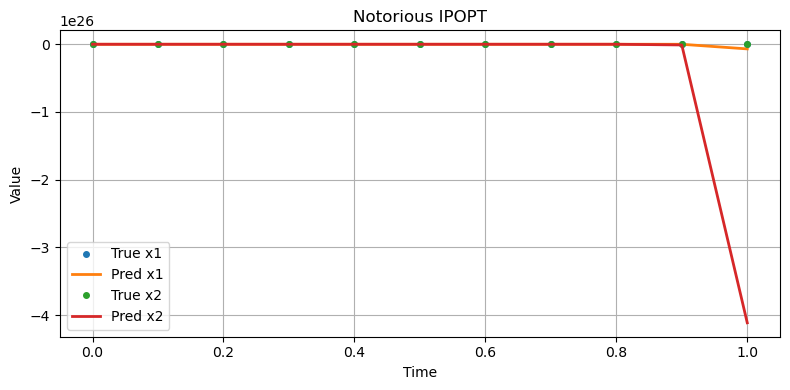

[Notorious GN] x1 Errors:
  RMSE = 2133278867735685787287552.0000
  MAE  = 644804083031863742955520.0000
  R2   = -21230996336419286714428037912860868970092385271808.0000
[Notorious GN] x2 Errors:
  RMSE = 127996732064141163343380480.0000
  MAE  = 38688244981911833704136704.0000
  R2   = -224659766829302075353421117963122477131943066468352.0000


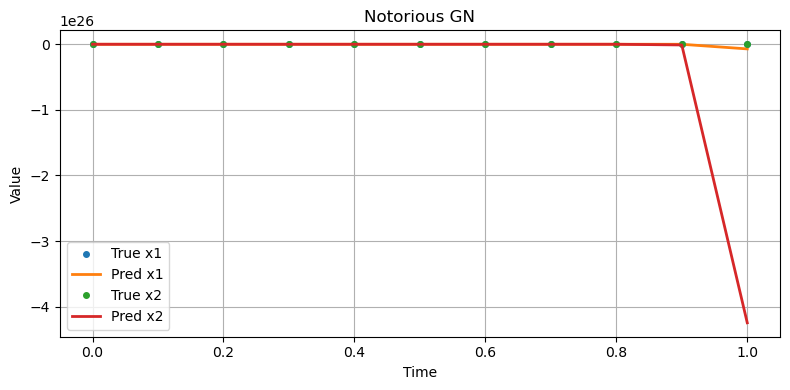

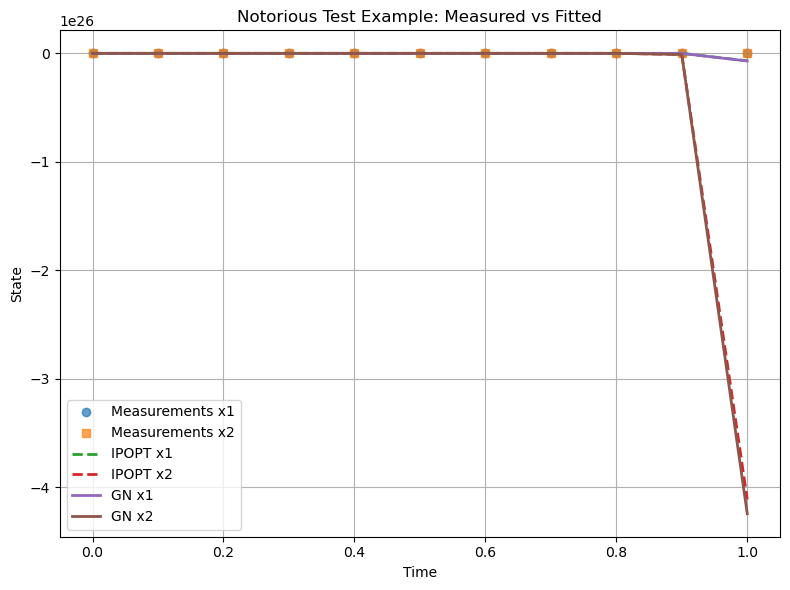

In [4]:
# ------ Notorious test example ------

# 参数
mu = 60.0
p_true_not = get_true_parameters()  # 正确函数名
x0_not = get_initial_state()        # 正确函数名
t_grid_not = np.linspace(0, 1, 11)  # 0, 0.1, ..., 1.0
N_not = len(t_grid_not) - 1
nx_not = 2
np_not = 1

# 生成合成测量数据
y_meas_not = simulate_notorious_measurements(mu, p_true_not, t_grid_not, noise_level=0.01)
y_meas_not[0, :] = [0.0, np.pi]

# 构建积分器（每段一个）
dt_not = t_grid_not[1] - t_grid_not[0]
F_not = make_notorious_integrator(dt_not, mu)

# 多段射击建模
w_not, X_end_not, g_not, S_vars_not, P_var_not = setup_multiple_shooting(F_not, N_not, nx_not, np_not)
# 拟合误差（观测点为1~N）
F1_not = ca.vertcat(*[X_end_not[i] - y_meas_not[i + 1] for i in range(N_not)])
# 初始猜测
w0_not = np.concatenate([y_meas_not[:-1].reshape(-1), [2.5]])

# IPOPT求解
sol_ipopt_not = solve_cnlls_ipopt(w=w_not, F1=F1_not, g=g_not, w0=w0_not)
w_opt_ipopt_not = sol_ipopt_not['x']
p_est_ipopt_not = w_opt_ipopt_not[-np_not:]
print("[Notorious][IPOPT] estimated parameter:", p_est_ipopt_not)

# Gauss-Newton求解（logparam）
sol_gn_not = solve_cnlls_gauss_newton_logparam(
    w=w_not, F1=F1_not, g=g_not, w0=w0_not, n_params=np_not
)
w_opt_gn_not = sol_gn_not['x']
p_est_gn_not = w_opt_gn_not[-np_not:]
print("[Notorious][GN] estimated parameter:", p_est_gn_not)

# 仿真轨迹
def notorious_simulate_with_integrator(p_est, mu, t_grid):
    dt = t_grid[1] - t_grid[0]
    integrator = make_notorious_integrator(dt, mu)
    x = np.array([0.0, np.pi])
    result = [x]
    for _ in range(len(t_grid) - 1):
        x = integrator(x0=x, p=p_est)['xf'].full().flatten()
        result.append(x)
    return np.array(result)

y_est_ipopt_not = notorious_simulate_with_integrator(p_est_ipopt_not, mu, t_grid_not)
y_est_gn_not = notorious_simulate_with_integrator(p_est_gn_not, mu, t_grid_not)

# 评估
evaluate_fit(y_meas_not, y_est_ipopt_not, t_grid_not, label="Notorious IPOPT", species_names=["x1", "x2"])
evaluate_fit(y_meas_not, y_est_gn_not, t_grid_not, label="Notorious GN", species_names=["x1", "x2"])

# 可视化
plt.figure(figsize=(8, 6))
plt.plot(t_grid_not, y_meas_not[:, 0], 'o', label='Measurements x1', alpha=0.7)
plt.plot(t_grid_not, y_meas_not[:, 1], 's', label='Measurements x2', alpha=0.7)
plt.plot(t_grid_not, y_est_ipopt_not[:, 0], '--', label='IPOPT x1', linewidth=2)
plt.plot(t_grid_not, y_est_ipopt_not[:, 1], '--', label='IPOPT x2', linewidth=2)
plt.plot(t_grid_not, y_est_gn_not[:, 0], '-', label='GN x1', linewidth=2)
plt.plot(t_grid_not, y_est_gn_not[:, 1], '-', label='GN x2', linewidth=2)
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Notorious Test Example: Measured vs Fitted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()